In [51]:
%pip install numpy
%pip install matplotlib
%pip install pandas


16770.84s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


16776.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


16782.49s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [52]:
import numpy as np
import pandas as pd
import random
import math
import time
import matplotlib.pyplot as plt
from typing import List, Tuple
from copy import deepcopy
from matplotlib.animation import FuncAnimation

In [53]:
# Keep this cell for MOGA class definition
class MOGA:
    """
    Working MOGA implementation for CVRP (giant-tour + split).
    Assumptions:
      - customer IDs are 1..N
      - depot is index 0 (not part of genome)
      - demands is a list/array of length N+1 where demands[0] == 0
      - customer_coords: list of N (x,y) tuples for customers 1..N
      - depot_coords: (x,y) tuple
    """

    def __init__(
        self, pop_size, crossover_rate, mutation_rate,
        customer_coords, depot_coords, demands,
        capacity, max_vehicles, seed = 0,
    ):
        random.seed(seed)
        np.random.seed(seed)

        self.pop_size = pop_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate

        self.customer_coords = customer_coords
        self.depot_coords = depot_coords
        self.demands = demands  # demands[0] must be depot (0)
        self.capacity = capacity
        self.max_vehicles = max_vehicles

        self.N = len(customer_coords)  # number of customers
        assert len(self.demands) == self.N + 1, "demands must have length N+1 with depot at index 0"

        # distance matrix: index 0 = depot, 1..N = customers
        self.dist_matrix = self._build_distance_matrix()

        # initialize population: list of lists (permutations of 1..N)
        self.population = [self.create_individual() for _ in range(self.pop_size)]

    # ---------- Representation & Initialization ----------
    def create_individual(self):
        """Return a random permutation of customers 1..N (list length N)."""
        indiv = list(range(1, self.N + 1))
        random.shuffle(indiv)
        return indiv
    
        # ---------- Distance matrix & evaluation ----------
    def _build_distance_matrix(self) -> np.ndarray:
        all_coords = [self.depot_coords] + list(self.customer_coords)
        n = len(all_coords)
        D = np.zeros((n, n), dtype=float)
        for i in range(n):
            xi, yi = all_coords[i]
            for j in range(n):
                xj, yj = all_coords[j]
                D[i, j] = math.hypot(xi - xj, yi - yj)
        return D

    # ---------- Split (greedy) ----------
    def split_routes(self, permutation):
        """
        Greedy split: scan permutation, start new route when adding next customer would exceed capacity.
        Each route is a list of customer IDs (no depot inside). Routes returned do not include depot.
        """
        routes = []
        current_route = []
        current_load = 0
        demands = self.demands

        for cust in permutation:
            demand = demands[cust]  # demands expected to have depot at index 0
            if current_load + demand > self.capacity:
                if current_route:
                    routes.append(current_route)
                current_route = [cust]
                current_load = demand
            else:
                current_route.append(cust)
                current_load += demand

        if current_route:
            routes.append(current_route)

        # simple repair: merge smallest routes until <= max_vehicles (greedy)
        # If merging any two smallest would exceed capacity, keep as is (we accept >max_vehicles rare case).
        while len(routes) > self.max_vehicles:
            # find two smallest by load
            loads = [sum(self.demands[c] for c in r) for r in routes]
            i1 = int(np.argmin(loads))
            r1 = routes.pop(i1)
            # recompute loads after removal
            loads = [sum(self.demands[c] for c in r) for r in routes]
            i2 = int(np.argmin(loads))
            r2 = routes.pop(i2)

            merged = r1 + r2
            if sum(self.demands[c] for c in merged) <= self.capacity:
                routes.append(merged)
            else:
                # cannot merge feasibly; put them back and stop attempting merges
                routes.append(r1)
                routes.append(r2)
                break

        return routes



    def evaluate_fitness(self, individual: List[int]) -> np.ndarray:
        """
        Returns two objectives:
          - total distance (sum of route lengths, each route starts/ends at depot)
          - std. dev. of route lengths
        """
        routes = self.split_routes(individual)
        if not routes:
            # shouldn't happen; give large penalties
            return np.array([1e9, 1e9])

        lengths = []
        for r in routes:
            if not r:
                continue
            indices = [0] + r + [0]  # depot at start and end
            path = self.dist_matrix[indices[:-1], indices[1:]]
            lengths.append(np.sum(path))

        total_dist = np.sum(lengths)
        sd = np.std(lengths)
        return np.array([total_dist, sd])

    # ---------- Non-dominated sort (fast) ----------
    def fast_non_dominated_sort(self, fitness_values):
        pop_size = len(fitness_values)
        fronts = [[]]
        dominated = [[] for _ in range(pop_size)]
        dom_count = [0] * pop_size

        for p in range(pop_size):
            for q in range(pop_size):
                if p == q:
                    continue
                # p dominates q?
                if np.all(fitness_values[p] <= fitness_values[q]) and np.any(fitness_values[p] < fitness_values[q]):
                    dominated[p].append(q)
                elif np.all(fitness_values[q] <= fitness_values[p]) and np.any(fitness_values[q] < fitness_values[p]):
                    dom_count[p] += 1
            if dom_count[p] == 0:
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in dominated[p]:
                    dom_count[q] -= 1
                    if dom_count[q] == 0:
                        next_front.append(q)
            i += 1
            fronts.append(next_front)

        return fronts[:-1]

    # ---------- Fitness sharing (MOGA diversity) ----------
    @staticmethod
    def sharing_function(distance, niche_radius):
        if distance < niche_radius:
            return 1.0 - (distance / niche_radius)
        return 0.0

    def calculate_niche_counts(self, fitness_values, front_indices, niche_radius):
        """
        Compute niche counts for the given subset of indices (e.g., a front).
        """
        n = len(front_indices)
        niche_counts = np.zeros(n)
        for i in range(n):
            for j in range(n):
                if i == j:
                    continue
                diff = fitness_values[front_indices[i]] - fitness_values[front_indices[j]]
                dist = math.sqrt(np.sum(diff ** 2))
                niche_counts[i] += self.sharing_function(dist, niche_radius)
        return niche_counts

    # ---------- Variation operators ----------
    def order_crossover(self, parent1, parent2):
        if random.random() > self.crossover_rate:
            return parent1.copy()
        
        size = len(parent1)
        a, b = sorted(random.sample(range(size), 2))
        child = [None] * size
        # copy slice from parent1
        child[a:b+1] = parent1[a:b+1]
        # fill remaining from parent2 in order
        p2_idx = 0
        for i in range(size):
            if child[i] is None:
                while parent2[p2_idx] in child:
                    p2_idx += 1
                child[i] = parent2[p2_idx]
                p2_idx += 1
        return child

    def swap_mutation(self, individual):
        if random.random() < self.mutation_rate:
            i, j = random.sample(range(len(individual)), 2)
            individual[i], individual[j] = individual[j], individual[i]
        return individual

    # ---------- Parent selection using MOGA (rank + sharing) ----------
    def compute_shared_fitnesses(self, fitness_values, niche_radius = None):
        """
        Compute a scalar 'shared fitness' for each individual.
        Approach:
          - Determine non-dominated fronts.
          - Assign base fitness by rank: f_base = 1 / (1 + rank_index)  (rank_index: 0 for best front)
          - Within each front compute niche counts and divide base fitness by (1 + niche_count).
          - Return array of length pop_size with shared fitness.
        """
        pop = len(fitness_values)
        if niche_radius is None:
            # heuristic niche radius: a small fraction of the range in objective space
            spans = fitness_values.max(axis=0) - fitness_values.min(axis=0)
            # avoid zeros
            spans[spans == 0] = 1.0
            niche_radius = 0.1 * np.linalg.norm(spans)

        fronts = self.fast_non_dominated_sort(fitness_values)
        shared = np.zeros(pop)

        for rank, front in enumerate(fronts):
            if not front:
                continue
            base_fit = 1.0 / (1 + rank)  # higher for better (lower rank) solutions
            # compute niche counts on this front
            niche_counts = self.calculate_niche_counts(fitness_values, front, niche_radius)
            for i, ind in enumerate(front):
                shared[ind] = base_fit / (1 + niche_counts[i])
        # small positive floor to avoid zeros
        shared = shared + 1e-12
        return shared

    # ---------- Evolutionary loop ----------
    def run(self, generations = 100, niche_radius = None):
        # Evaluate initial population
        fitness_values = np.array([self.evaluate_fitness(ind) for ind in self.population])

        for gen in range(generations):
            # Compute shared fitnesses for parent selection
            shared_fit = self.compute_shared_fitnesses(fitness_values, niche_radius)

            # Keep old population for elitism
            old_population = self.population.copy()
            old_fitness_values = fitness_values.copy()

            # Sample parents and create offspring
            new_population = []
            while len(new_population) < self.pop_size:
                parents_idx = np.random.choice(
                    self.pop_size, size=2, replace=False, p=shared_fit / shared_fit.sum()
                )
                p1 = self.population[parents_idx[0]]
                p2 = self.population[parents_idx[1]]
                child = self.order_crossover(p1, p2)
                child = self.swap_mutation(child)
                new_population.append(child)

            # Evaluate new population
            self.population = new_population
            fitness_values = np.array([self.evaluate_fitness(ind) for ind in self.population])

            # Elitism: keep best individual from previous generation
            fronts_old = self.fast_non_dominated_sort(old_fitness_values)
            elite_idx = fronts_old[0][0]  # first individual in best front
            # Replace worst individual in new population
            shared_fit_new = self.compute_shared_fitnesses(fitness_values, niche_radius)
            worst_idx = np.argmin(shared_fit_new)
            self.population[worst_idx] = old_population[elite_idx]
            fitness_values[worst_idx] = old_fitness_values[elite_idx]

            if gen % 50 == 0 or gen == generations-1:
                print(f"Generation {gen}: Best distance = {fitness_values[elite_idx][0]:.2f}, SD = {fitness_values[elite_idx][1]:.2f}")

        # After all generations, return Pareto front
        fronts = self.fast_non_dominated_sort(fitness_values)
        best_front = fronts[0] if fronts else []
        pareto_solutions = [self.population[i] for i in best_front]
        pareto_fitnesses = fitness_values[best_front] if len(best_front) > 0 else np.array([])
        return pareto_solutions, pareto_fitnesses


    def get_population_fitness(self):
        return np.array([self.evaluate_fitness(ind) for ind in self.population])
    
    def get_routes_with_depot(self, individual):
        """Return routes with depot (0) explicitly included at start/end."""
        raw_routes = self.split_routes(individual)
        routes_with_depot = []
        for r in raw_routes:
            routes_with_depot.append([0] + r + [0])
        return routes_with_depot




In [54]:
def read_cvrp(file_path):
    instance_data = {'coordinates': {}, 'demands': {}, 'depot': None, 'capacity': None}
    with open(file_path, 'r') as f:
        lines = f.readlines()
    section = None
    for line in lines:
        line = line.strip()
        if line.startswith('CAPACITY'):
            instance_data['capacity'] = int(line.split(':')[1])
        elif line.startswith('NODE_COORD_SECTION'):
            section = 'coords'
        elif line.startswith('DEMAND_SECTION'):
            section = 'demands'
        elif line.startswith('DEPOT_SECTION'):
            section = 'depot'
        elif line == 'EOF' or line == '':
            continue
        elif section == 'coords':
            parts = line.split()
            instance_data['coordinates'][int(parts[0])] = (float(parts[1]), float(parts[2]))
        elif section == 'demands':
            parts = line.split()
            instance_data['demands'][int(parts[0])] = int(parts[1])
        elif section == 'depot':
            if line == '-1':
                continue
            instance_data['depot'] = int(line)
    return instance_data

def prepare_instance(instance_data):
    coords = instance_data['coordinates']
    demands = instance_data['demands']
    depot_id = instance_data['depot']
    capacity = instance_data['capacity']
    depot_coords = coords[depot_id]
    customer_ids = sorted([i for i in coords.keys() if i != depot_id])
    customer_coords = np.array([coords[i] for i in customer_ids], dtype=float)
    demand_array = np.zeros(len(customer_ids) + 1, dtype=float)
    for idx, cid in enumerate(customer_ids):
        demand_array[idx + 1] = demands[cid]
    return depot_coords, customer_coords, demand_array, capacity

def plot_pareto_front(pareto_fits, title="MOGA Pareto Front"):
    pareto_fits = np.array(pareto_fits)
    import matplotlib.pyplot as plt

    # Sort points for nicer line plot
    sorted_idx = np.argsort(pareto_fits[:,0])
    pareto_sorted = pareto_fits[sorted_idx]

    plt.figure(figsize=(7,5))
    # Line plot
    plt.plot(pareto_sorted[:,0], pareto_sorted[:,1], '-o', color='red', alpha=0.7, label="Pareto Front")
    # Scatter plot
    plt.scatter(pareto_fits[:,0], pareto_fits[:,1], c='blue', s=60, alpha=0.7, label="Solutions")

    plt.xlabel("Total Distance")
    plt.ylabel("Route Balance (Std Dev)")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

def plot_all_fronts(all_fronts, global_front, title="Pareto Fronts Across Runs"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7, 5))

    # Plot all run-specific fronts (faint blue)
    for front in all_fronts:
        if len(front) > 0:
            plt.scatter(front[:, 0], front[:, 1],
                        c="blue", alpha=0.3, s=30, label="_nolegend_")

    # Plot global Pareto front (highlighted red line)
    sorted_idx = np.argsort(global_front[:, 0])
    global_sorted = global_front[sorted_idx]
    plt.plot(global_sorted[:, 0], global_sorted[:, 1],
             "-o", color="red", lw=2, ms=6, label="Global Pareto Front")

    plt.xlabel("Total Distance")
    plt.ylabel("Route Balance (Std Dev)")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


In [ ]:
def run_single_moga(
    depot_coords, customer_coords, demands, capacity,
    pop_size=100, generations=500, max_vehicles=5, seed=0,
    crossover_rate=0.7, mutation_rate=0.2,
):
    start_time = time.time()
    moga = MOGA(
        pop_size=pop_size,
        crossover_rate=crossover_rate,
        mutation_rate=mutation_rate,
        customer_coords=customer_coords,
        depot_coords=depot_coords,
        demands=demands,
        capacity=capacity,
        max_vehicles=max_vehicles,
        seed=seed,
    )
    pareto_sols, pareto_fits = moga.run(generations=generations)
    end_time = time.time()
    elapsed = end_time - start_time
    for i, (sol, fit) in enumerate(zip(pareto_sols, pareto_fits)):
        print(f"\nSolution {i+1} | Fitness = {fit}")
        routes = moga.get_routes_with_depot(sol)
        for j, r in enumerate(routes):
            print(f"  Route {j+1}: {r}")
    return pareto_sols, pareto_fits, elapsed


def merge_fronts(all_fronts):
    # Merge all solutions into one big pool and extract non-dominated front
    all_points = np.vstack(all_fronts)

    is_efficient = np.ones(len(all_points), dtype=bool)
    for i, p in enumerate(all_points):
        if is_efficient[i]:
            dominates = np.all(all_points <= p, axis=1) & np.any(all_points < p, axis=1)
            dominates[i] = False  # ignore self
            if np.any(dominates):
                is_efficient[i] = False
    return all_points[is_efficient]


def run_experiments_multiple_files(
    file_configs,
    pop_size=100,
    generations=500,
    runs=20,
    run_fn=run_single_moga,
):
    """
    Run experiments on multiple .vrp files with independent configs.

    Args:
        file_configs (List[dict]): List of dicts for each file with keys:
            - 'file_path': str, path to .vrp file
            - 'max_vehicles': int, optional, default 5
            - 'pop_size', 'generations', 'runs', optional per file
            - 'seeds': list of ints or None, if None seeds = range(runs)
        pop_size, generations, runs: defaults if not specified per file

    Returns:
        results: dict mapping file_path to dict with:
            - 'all_fronts': list of pareto_fits per run
            - 'global_front': merged front from all runs
            - 'times': list of run durations
    """
    results = {}

    for cfg in file_configs:
        file_path = cfg['file_path']
        max_vehicles = cfg.get('max_vehicles', 5)
        local_pop_size = cfg.get('pop_size', pop_size)
        local_generations = cfg.get('generations', generations)
        local_runs = cfg.get('runs', runs)

        print(f"\n=== Running file: {file_path} with {local_runs} runs ===")
        raw = read_cvrp(file_path)
        depot_coords, customer_coords, demands, capacity = prepare_instance(raw)

        all_fronts = []
        times = []

        for i in range(local_runs):
            print(f"Run {i+1}/{local_runs}")
            _, pareto_fits, elapsed = run_fn(
                depot_coords, customer_coords, demands, capacity,
                pop_size=local_pop_size,
                generations=local_generations,
                max_vehicles=max_vehicles,
                seed=i,
            )
            all_fronts.append(pareto_fits)
            times.append(elapsed)
            print(f"Run time: {elapsed:.2f} seconds")

        global_front = merge_fronts(all_fronts)
        results[file_path] = {
            'all_fronts': all_fronts,
            'global_front': global_front,
            'times': times,
        }

    return results

file_configs = [
    {
        'file_path': 'A-n32-k5.vrp',
        'max_vehicles': 5,
    },
        {
        'file_path': 'A-n60-k9.vrp',
        'max_vehicles': 9,
    },
    {
        'file_path': 'B-n78-k10.vrp',
        'max_vehicles': 10,
    },
    {
        'file_path': 'A-n80-k10.vrp',
        'max_vehicles': 10,
    },
    {
        'file_path': 'X-n101-k25.vrp',
        'max_vehicles': 25,
    },
    {
        'file_path': 'X-n384-k52.vrp',
        'max_vehicles': 52,
    },
]


In [56]:
def plot_all_results(results, title_prefix="MOGA CVRP Results"):
    """
    Plot Pareto fronts for all instances and runs.

    Args:
        results (dict): Output from run_experiments_multiple_files
        title_prefix (str): Prefix for plot titles
    """
    for file_path, data in results.items():
        all_fronts = data['all_fronts']
        global_front = data['global_front']

        plt.figure(figsize=(8, 6))
        # Plot all run-specific fronts in faint blue
        for front in all_fronts:
            if front is not None and len(front) > 0:
                plt.scatter(front[:, 0], front[:, 1],
                            c='blue', alpha=0.3, s=30, label="_nolegend_")

        # Plot global Pareto front as highlighted red line
        if global_front is not None and len(global_front) > 0:
            sorted_idx = np.argsort(global_front[:, 0])
            global_sorted = global_front[sorted_idx]
            plt.plot(global_sorted[:, 0], global_sorted[:, 1],
                     '-o', color='red', lw=2, ms=6, label="Global Pareto Front")

        plt.xlabel("Total Distance")
        plt.ylabel("Route Balance (Std Dev)")
        plt.title(f"{title_prefix} - {file_path}")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()



In [57]:
moga_results = run_experiments_multiple_files(file_configs, run_fn=run_single_moga, runs=1)


=== Running file: A-n32-k5.vrp with 1 runs ===
Run 1/1
Generation 0: Best distance = 2183.87, SD = 92.73
Generation 50: Best distance = 2018.63, SD = 135.11
Generation 100: Best distance = 1303.81, SD = 75.56
Generation 150: Best distance = 1553.19, SD = 31.33
Generation 200: Best distance = 1247.54, SD = 25.91
Generation 250: Best distance = 1613.40, SD = 77.23
Generation 300: Best distance = 1259.21, SD = 23.50
Generation 350: Best distance = 1388.52, SD = 15.74
Generation 400: Best distance = 1585.37, SD = 87.38
Generation 450: Best distance = 1283.01, SD = 33.35
Generation 499: Best distance = 1497.19, SD = 67.31

Solution 1 | Fitness = [1309.34511487   19.78239252]
  Route 1: [0, 27, 9, 18, 8, 28, 23, 31, 21, 0]
  Route 2: [0, 4, 11, 10, 25, 24, 14, 0]
  Route 3: [0, 16, 7, 26, 17, 19, 3, 0]
  Route 4: [0, 2, 13, 1, 30, 6, 0]
  Route 5: [0, 12, 20, 5, 29, 15, 22, 0]

Solution 2 | Fitness = [1216.40116331   31.14732495]
  Route 1: [0, 27, 18, 9, 8, 28, 23, 31, 21, 0]
  Route 2: [0

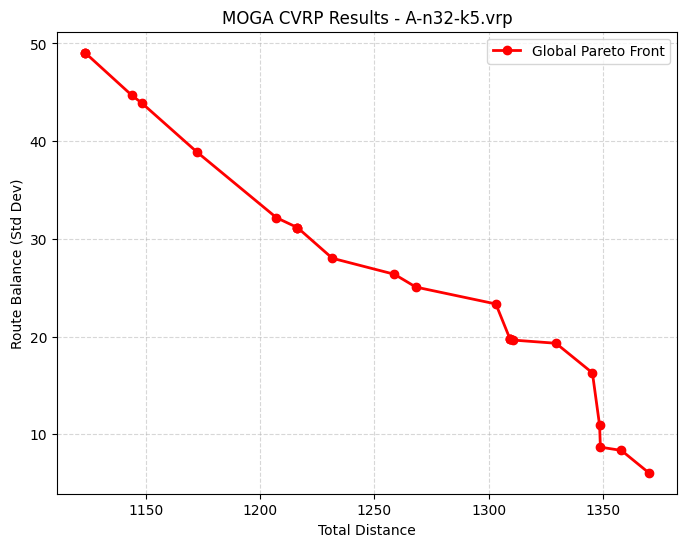

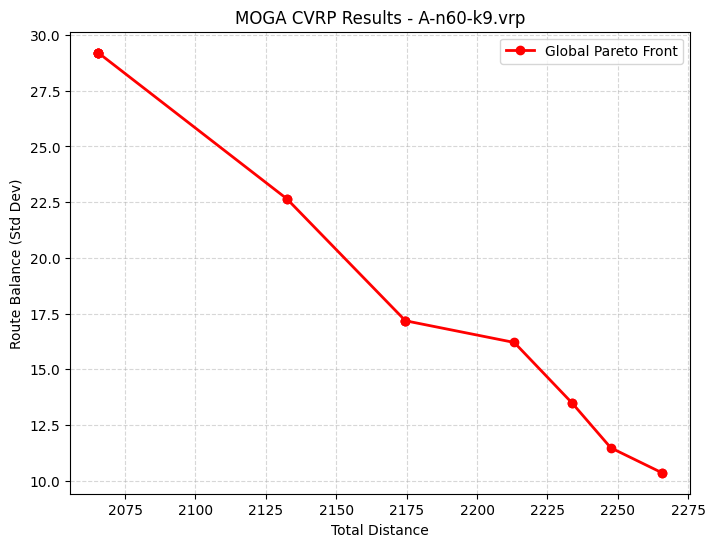

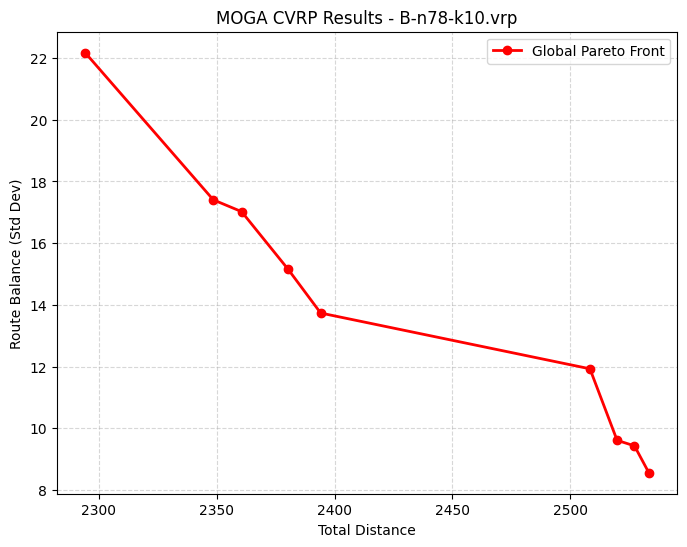

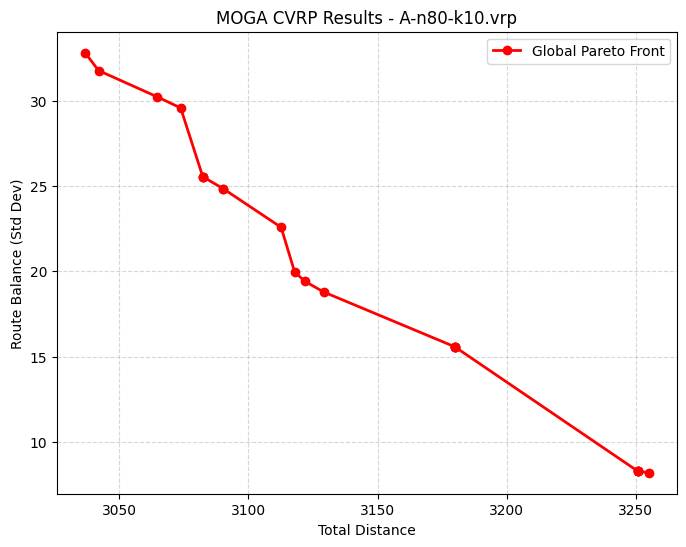

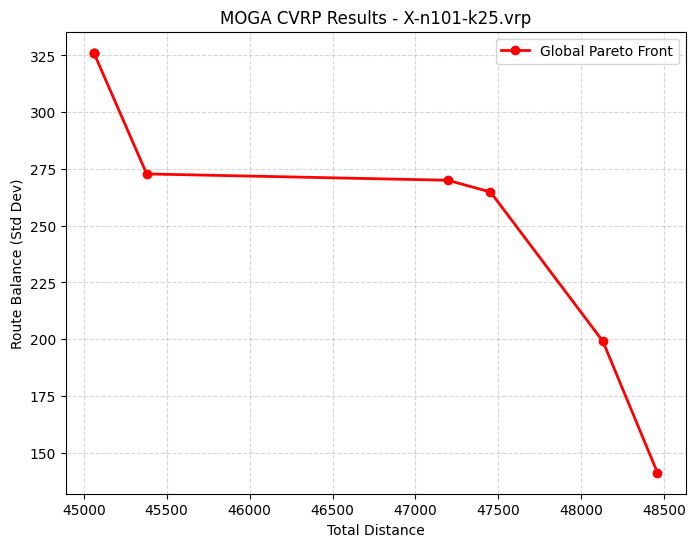

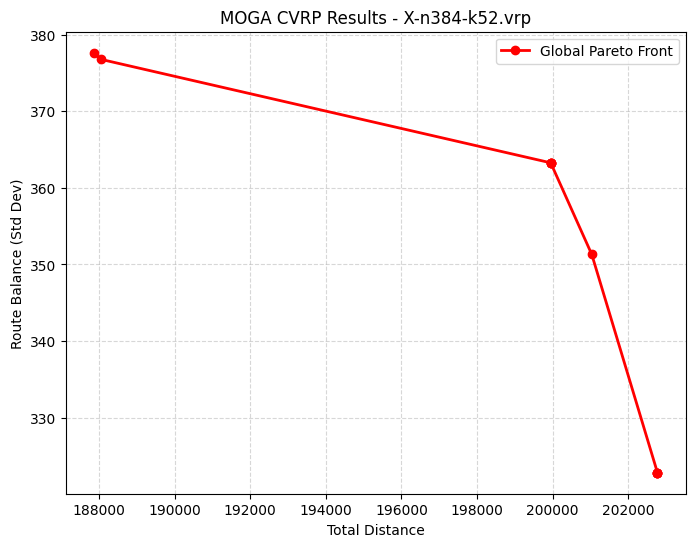

In [58]:
plot_all_results(moga_results, title_prefix="MOGA CVRP Results")

# NSGA 2

In [ ]:
class Solution:
    def __init__(self, x):
        self.x = x
        self.objectives = None
        self.rank = None
        self.crowding_distance = None

class NSGA2:
    def __init__(
        self,
        pop_size: int,
        crossover_rate: float,
        mutation_rate: float,
        customer_coords: List[Tuple[float, float]],
        depot_coords: Tuple[float, float],
        demands: List[float],
        capacity: float,
        max_vehicles: int,
        seed: int = 0,
    ):
        self.pop_size = pop_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.customer_coords = customer_coords
        self.depot_coords = depot_coords
        self.demands = demands
        assert self.demands[0] == 0, "Demands must include depot at index 0 with demand 0"

        self.capacity = capacity
        self.max_vehicles = max_vehicles
        self.seed = seed
        self.population_history = []
        self.distance_matrix = self._build_distance_matrix()

        random.seed(seed)
        np.random.seed(seed)

    def create_individual(self) -> List[int]:
        indiv = list(range(1, len(self.customer_coords) + 1))
        random.shuffle(indiv)
        return indiv
    
    def _build_distance_matrix(self) -> np.ndarray:
        all_coords = [self.depot_coords] + list(self.customer_coords)
        n = len(all_coords)
        D = np.zeros((n, n), dtype=float)
        for i in range(n):
            xi, yi = all_coords[i]
            for j in range(n):
                xj, yj = all_coords[j]
                D[i, j] = math.hypot(xi - xj, yi - yj)
        return D
    
    def initialize_population(self) -> List[Solution]:
        return [Solution(self.create_individual()) for _ in range(self.pop_size)]
    

    def split_routes(self, permutation: List[int]) -> List[List[int]]:
        """
        Greedy split: scan permutation, start new route when adding next customer would exceed capacity.
        Each route is a list of customer IDs (no depot inside). Routes returned do not include depot.
        """
        routes: List[List[int]] = []
        current_route: List[int] = []
        current_load = 0

        for cust in permutation:
            d = self.demands[cust]  # demands expected to have depot at index 0
            if current_load + d > self.capacity:
                if current_route:
                    routes.append(current_route)
                current_route = [cust]
                current_load = d
            else:
                current_route.append(cust)
                current_load += d

        if current_route:
            routes.append(current_route)

        # simple repair: merge smallest routes until <= max_vehicles (greedy)
        # If merging any two smallest would exceed capacity, keep as is (we accept >max_vehicles rare case).
        while len(routes) > self.max_vehicles:
            # find two smallest by load
            loads = [sum(self.demands[c] for c in r) for r in routes]
            i1 = int(np.argmin(loads))
            r1 = routes.pop(i1)
            # recompute loads after removal
            loads = [sum(self.demands[c] for c in r) for r in routes]
            i2 = int(np.argmin(loads))
            r2 = routes.pop(i2)
            merged = r1 + r2
            if sum(self.demands[c] for c in merged) <= self.capacity:
                routes.append(merged)
            else:
                # cannot merge feasibly; put them back and stop attempting merges
                routes.append(r1)
                routes.append(r2)
                break

        return routes

    
    def evalute_objectives(self, population):
        for solution in population:
            solution.objectives = np.array([
                self.objective_total_distance(solution.x),
                self.objective_route_balance(solution.x)], dtype=float)


    def dominates(self, p, q):
        return all(p_obj <= q_obj for p_obj, q_obj in zip(p.objectives, q.objectives)) and \
            any(p_obj < q_obj for p_obj, q_obj in zip(p.objectives, q.objectives))
    
    def non_dominated_sort(self, population: List[Solution]):
        for p in population:
            p.domination_count = 0
            p.dominated_solutions = []
            for q in population:
                if self.dominates(p, q):
                    p.dominated_solutions.append(q)
                elif self.dominates(q, p):
                    p.domination_count += 1
            if p.domination_count == 0:
                p.rank = 1
        front = 1
        while True:
            current_front = [p for p in population if p.rank == front]
            if not current_front:
                break
            for p in current_front:
                for q in p.dominated_solutions:
                    q.domination_count -= 1
                    if q.domination_count == 0:
                        q.rank = front + 1
            front += 1


    def calculate_crowding_distance(self, population):
        for p in population:
            p.crowding_distance = 0
        
        for obj in range(num_objectives := 2):
            population.sort(key=lambda sol: sol.objectives[obj])
            population[0].crowding_distance = population[-1].crowding_distance = float('inf')
            obj_range = population[-1].objectives[obj] - population[0].objectives[obj]
            if obj_range == 0:
                continue
            for i in range(1, len(population) - 1):
                population[i].crowding_distance += (population[i + 1].objectives[obj] - population[i - 1].objectives[obj]) / obj_range


    def tournament_selection(self, population):
        a, b = random.sample(population, 2,)
        if a.rank < b.rank or (a.rank == b.rank and a.crowding_distance > b.crowding_distance):
            return a
        return b
    
    
    def crossover(self, parent1: List[int], parent2: List[int]) -> List[int]:
        size = len(parent1)
        if random.random() > self.crossover_rate:
            return parent1.copy()

        a, b = sorted(random.sample(range(size), 2))
        child = [None] * size
        # copy slice from parent1
        child[a:b+1] = parent1[a:b+1]
        # fill remaining from parent2 in order
        p2_idx = 0
        for i in range(size):
            if child[i] is None:
                while parent2[p2_idx] in child:
                    p2_idx += 1
                child[i] = parent2[p2_idx]
                p2_idx += 1
        return child
    
    
    def mutation(self, individual: List[int]) -> List[int]:
        if random.random() < self.mutation_rate:
            i, j = random.sample(range(len(individual)), 2)
            individual[i], individual[j] = individual[j], individual[i]
        return individual
    
    def create_offspring(self, population):
        offspring = []
        while len(offspring) < self.pop_size:
            p1 = self.tournament_selection(population)
            p2 = self.tournament_selection(population)
            child_x = self.crossover(p1.x, p2.x)
            child_x = self.mutation(child_x)
            offspring.append(Solution(child_x))
        return offspring
    
    def select_next_generation(self, population, offspring):
        combined = population + offspring
        self.non_dominated_sort(combined)
        self.calculate_crowding_distance(combined)
        combined.sort(key=lambda sol: (sol.rank, -sol.crowding_distance))
        return combined[:self.pop_size]
    
    def route_distance(self, route):
        dist = self.distance_matrix[0, route[0]]  # depot to first
        for i in range(len(route) - 1):
            dist += self.distance_matrix[route[i], route[i + 1]]
        dist += self.distance_matrix[route[-1], 0]  # last to depot
        return dist
    
    def objective_total_distance(self, individual: List[int]) -> float:
        routes = self.split_routes(individual)
        total_distance = sum(self.route_distance(r) for r in routes)
        return total_distance
    
    def objective_route_balance(self, individual: List[int]) -> float:
        routes = self.split_routes(individual)
        if len(routes) == 0:
            return float('inf')
        route_lengths = [self.route_distance(r) for r in routes]
        return np.std(route_lengths)
    
    def run(self, generations: int = 500):
        population = self.initialize_population()
        self.evalute_objectives(population)
        for gen in range(generations):
            self.evalute_objectives(population)
            self.non_dominated_sort(population)
            self.calculate_crowding_distance(population)
            self.population_history.append(deepcopy(population))

            offspring = self.create_offspring(population)
            self.evalute_objectives(offspring)
            population = self.select_next_generation(population, offspring)
        
        self.evalute_objectives(population)
        self.non_dominated_sort(population)
        return population
        
    


In [60]:
# Example usage for any CVRPLIB .vrp file:
instance_file = "A-n32-k5.vrp"
instance = read_cvrp(instance_file)
depot_coords, customer_coords, demands, capacity = prepare_instance(instance)

In [61]:
# Setup your problem data
nsga2 = NSGA2(
    pop_size=100,
    crossover_rate=0.7,
    mutation_rate=0.2,
    customer_coords=customer_coords,
    depot_coords=depot_coords,
    demands=demands,
    capacity=capacity,
    max_vehicles=5
)

# Run
now = time.time()
final_population = nsga2.run(generations=500)
end = time.time()
print("Elapsed time:", end-now)

# Display Pareto front
pareto_front = [s for s in final_population if s.rank == 1]
for sol in pareto_front:
    print("Objectives:", sol.objectives)


Elapsed time: 32.168931007385254
Objectives: [1.55610828e+03 4.31080210e-01]
Objectives: [1113.33710378   21.49558362]
Objectives: [1140.11557741   14.19511525]
Objectives: [1121.76480289   19.82417803]
Objectives: [1145.1713411    11.52712802]
Objectives: [1182.57311557    5.8589738 ]
Objectives: [1193.18496852    3.73758292]
Objectives: [1182.57311557    5.8589738 ]
Objectives: [1528.03693589    1.58684843]
Objectives: [1121.76480289   19.82417803]
Objectives: [1181.92929785    6.89875939]
Objectives: [1497.20715241    3.11319868]
Objectives: [1113.33710378   21.49558362]
Objectives: [1117.86051229   19.88766517]
Objectives: [1172.62314517    7.08408256]
Objectives: [1151.43519874   10.30946837]
Objectives: [1178.56745973    7.03692797]
Objectives: [1.55610828e+03 4.31080210e-01]
Objectives: [1172.14573487    7.34437692]
Objectives: [1497.20715241    3.11319868]
Objectives: [1145.1713411    11.52712802]
Objectives: [1144.12943361   13.55999956]
Objectives: [1492.34341778    3.6479632

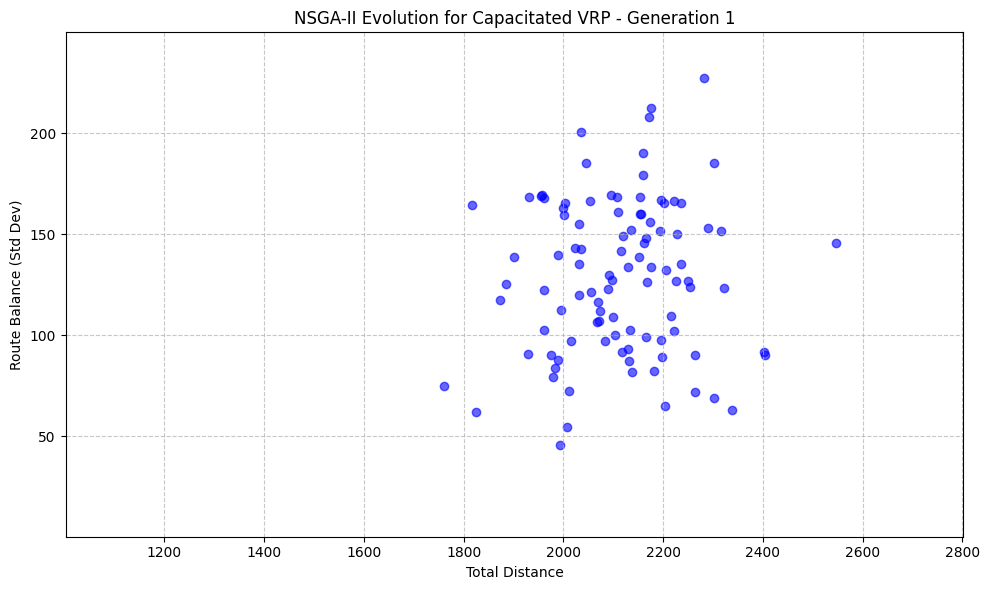

Final Pareto Front:
Objectives: [1.55610828e+03 4.31080210e-01]
Objectives: [1113.33710378   21.49558362]
Objectives: [1140.11557741   14.19511525]
Objectives: [1121.76480289   19.82417803]
Objectives: [1145.1713411    11.52712802]
Objectives: [1182.57311557    5.8589738 ]
Objectives: [1193.18496852    3.73758292]
Objectives: [1182.57311557    5.8589738 ]
Objectives: [1528.03693589    1.58684843]
Objectives: [1121.76480289   19.82417803]
Objectives: [1181.92929785    6.89875939]
Objectives: [1497.20715241    3.11319868]
Objectives: [1113.33710378   21.49558362]
Objectives: [1117.86051229   19.88766517]
Objectives: [1172.62314517    7.08408256]
Objectives: [1151.43519874   10.30946837]
Objectives: [1178.56745973    7.03692797]
Objectives: [1.55610828e+03 4.31080210e-01]
Objectives: [1172.14573487    7.34437692]
Objectives: [1497.20715241    3.11319868]
Objectives: [1145.1713411    11.52712802]
Objectives: [1144.12943361   13.55999956]
Objectives: [1492.34341778    3.64796328]
Objectives

In [62]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter([], [], c='blue', alpha=0.6)

all_objs = [sol.objectives for pop in nsga2.population_history for sol in pop]
x_vals, y_vals = zip(*all_objs)
ax.set_xlim(min(x_vals)*0.9, max(x_vals)*1.1)
ax.set_ylim(min(y_vals)*0.9, max(y_vals)*1.1)
ax.set_title('NSGA-II Evolution')
ax.set_xlabel('Total Distance')
ax.set_ylabel('Route Balance (Std Dev)')
ax.grid(True, linestyle='--', alpha=0.7)

# Animation update function
def update(frame):
    population = nsga2.population_history[frame]
    x = [solution.objectives[0] for solution in population]
    y = [solution.objectives[1] for solution in population]
    scatter.set_offsets(np.c_[x, y])
    ax.set_title(f'NSGA-II Evolution for Capacitated VRP - Generation {frame+1}')
    return scatter,

# Create the animation
anim = FuncAnimation(fig, update, frames=len(nsga2.population_history), 
                     interval=200, blit=True, repeat=False)

plt.tight_layout()
plt.show()

# Optionally, save the animation
anim.save('nsga2_evolution.gif', writer='pillow', fps=5)

# Print final Pareto front
pareto_front = [p for p in final_population if p.rank == 1]
print("Final Pareto Front:")
for solution in pareto_front:
    print(f"Objectives: {solution.objectives}")

In [69]:
def run_single_nsga2(
    depot_coords, customer_coords, demands, capacity,
    pop_size=100, generations=500, max_vehicles=5, seed=0,
    crossover_rate=0.7, mutation_rate=0.2,
):
    start_time = time.time()
    nsga2 = NSGA2(
        pop_size=pop_size,
        crossover_rate=crossover_rate,
        mutation_rate=mutation_rate,
        customer_coords=customer_coords,
        depot_coords=depot_coords,
        demands=demands,
        capacity=capacity,
        max_vehicles=max_vehicles,
        seed=seed,
    )
    
    final_population = nsga2.run(generations=generations)
    
    # Extract Pareto front (solutions with rank 1)
    pareto_sols = [s for s in final_population if s.rank == 1]
    pareto_fits = np.array([s.objectives for s in pareto_sols])
    
    end_time = time.time()
    elapsed = end_time - start_time
    
    # Output solutions (optional)
    for i, (sol, fit) in enumerate(zip(pareto_sols, pareto_fits)):
        print(f"\nSolution {i+1} | Fitness = {fit}")
        routes = nsga2.split_customers_capacitated(sol.x)
        for j, r in enumerate(routes):
            print(f"  Route {j+1}: [0, {' -> '.join(map(str, r))}, 0]")
    
    return [s.x for s in pareto_front], pareto_fits, elapsed


In [70]:
results_nsga2 = run_experiments_multiple_files(file_configs, run_fn=run_single_nsga2, runs=1)



=== Running file: A-n32-k5.vrp with 1 runs ===
Run 1/1

Solution 1 | Fitness = [1.55610828e+03 4.31080210e-01]
  Route 1: [0, 25 -> 10 -> 15 -> 8 -> 11 -> 18 -> 14 -> 12, 0]
  Route 2: [0, 26 -> 6 -> 9 -> 29 -> 23 -> 2 -> 3 -> 27, 0]
  Route 3: [0, 30 -> 7 -> 17 -> 31 -> 21 -> 20 -> 13, 0]
  Route 4: [0, 16 -> 19 -> 24 -> 4 -> 28, 0]
  Route 5: [0, 5 -> 1 -> 22, 0]

Solution 2 | Fitness = [1113.33710378   21.49558362]
  Route 1: [0, 25 -> 10 -> 15 -> 22 -> 8 -> 18 -> 14 -> 24, 0]
  Route 2: [0, 16 -> 6 -> 23 -> 28 -> 29 -> 5 -> 27, 0]
  Route 3: [0, 1 -> 21 -> 31 -> 19 -> 17 -> 26 -> 20, 0]
  Route 4: [0, 12 -> 7 -> 13 -> 2 -> 3 -> 30, 0]
  Route 5: [0, 9 -> 11 -> 4, 0]

Solution 3 | Fitness = [1140.11557741   14.19511525]
  Route 1: [0, 25 -> 10 -> 15 -> 22 -> 8 -> 18 -> 14 -> 24, 0]
  Route 2: [0, 16 -> 6 -> 23 -> 28 -> 29 -> 5 -> 27, 0]
  Route 3: [0, 12 -> 21 -> 31 -> 17 -> 7 -> 30 -> 20, 0]
  Route 4: [0, 1 -> 13 -> 19 -> 2 -> 3 -> 26, 0]
  Route 5: [0, 9 -> 11 -> 4, 0]

Solution

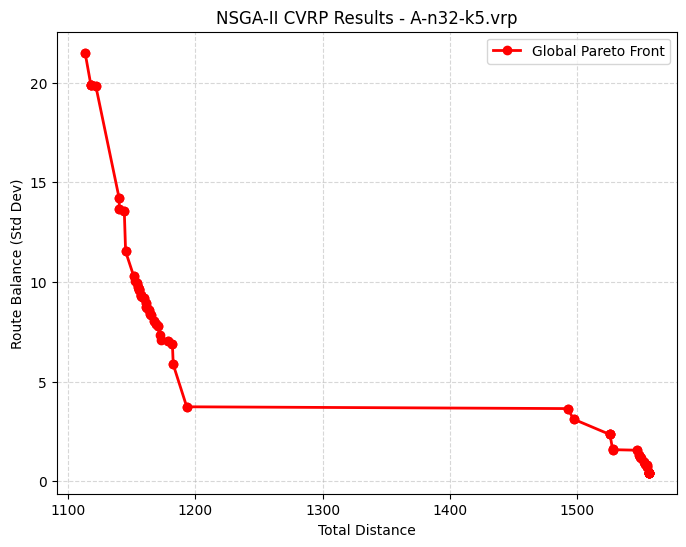

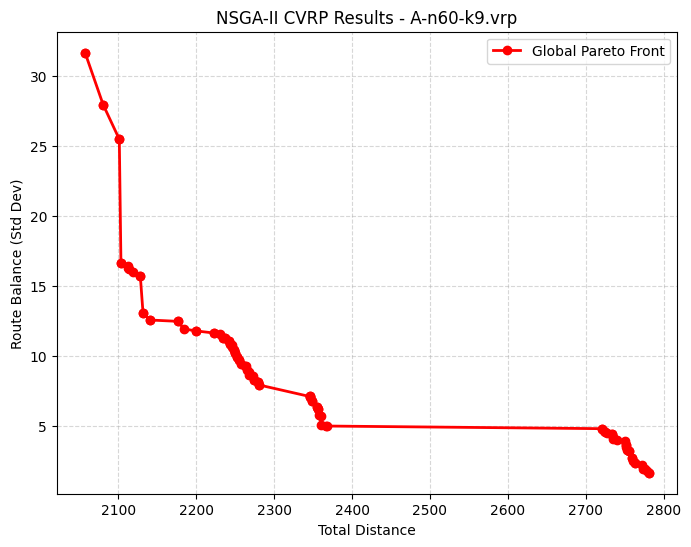

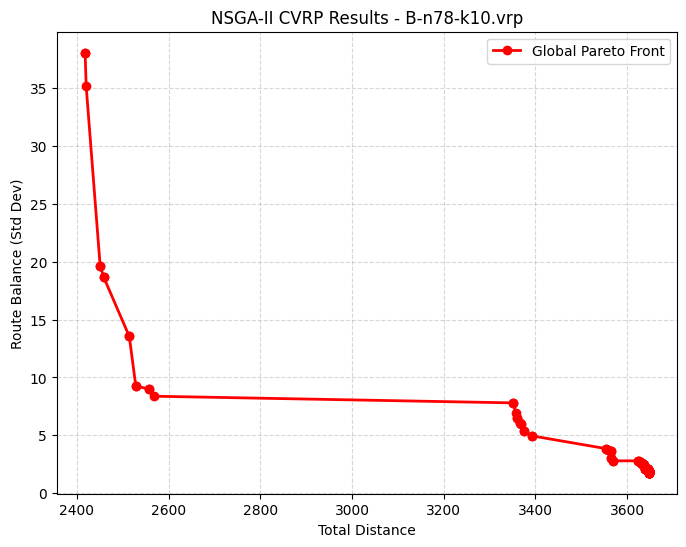

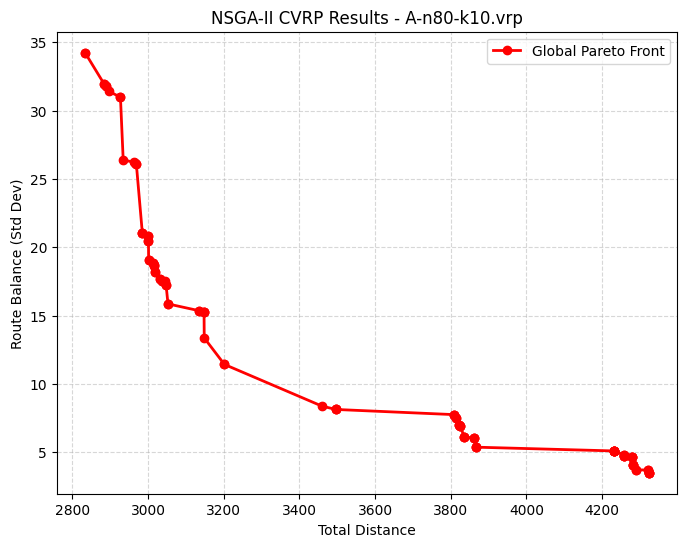

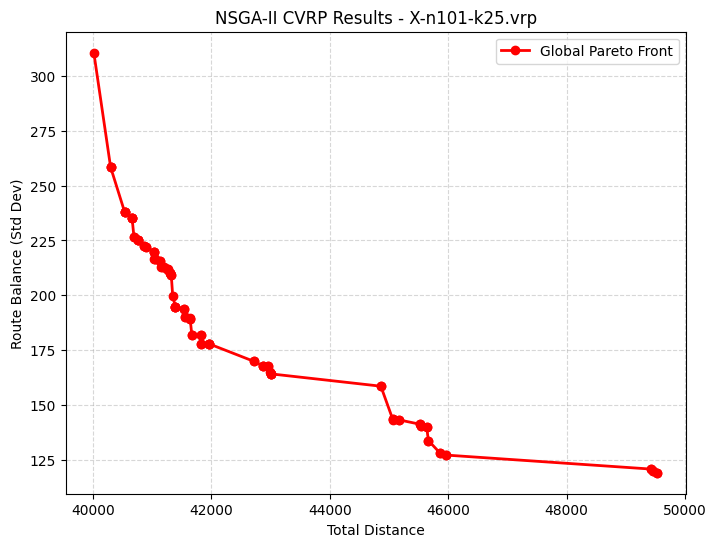

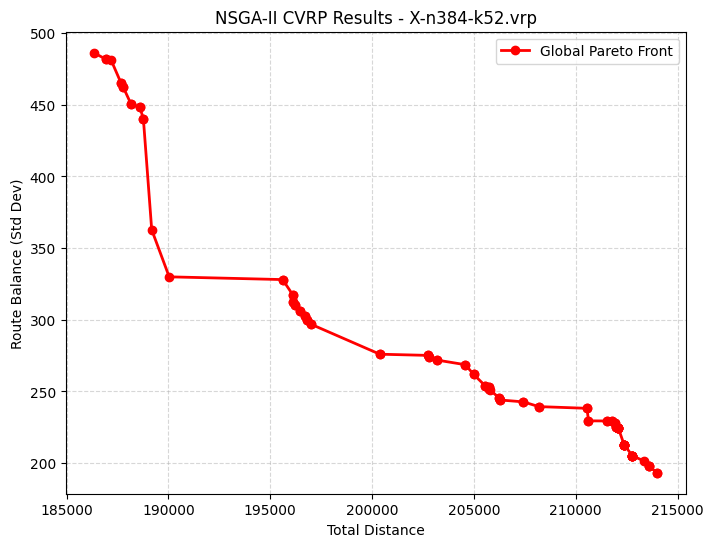

In [71]:
plot_all_results(results_nsga2, title_prefix="NSGA-II CVRP Results")

In [ ]:
def dominates(p_fitness, q_fitness):
    return all(p <= q for p, q in zip(p_fitness, q_fitness)) and \
           any(p < q for p, q in zip(p_fitness, q_fitness))

def non_dominated_sorting(fitness_values):
    population_size = len(fitness_values)
    domination_counts = [0] * population_size
    dominated_solutions = [[] for _ in range(population_size)]
    ranks = [0] * population_size
    fronts = [[]]

    for p in range(population_size):
        for q in range(population_size):
            if p == q:
                continue
            if dominates(fitness_values[p], fitness_values[q]):
                dominated_solutions[p].append(q)
            elif dominates(fitness_values[q], fitness_values[p]):
                domination_counts[p] += 1

        if domination_counts[p] == 0:
            ranks[p] = 1
            fronts[0].append(p)

    current_front = 0
    while fronts[current_front]:
        next_front = []
        for p in fronts[current_front]:
            for q in dominated_solutions[p]:
                domination_counts[q] -= 1
                if domination_counts[q] == 0:
                    ranks[q] = current_front + 2
                    next_front.append(q)
        current_front += 1
        fronts.append(next_front)

    return fronts[:-1]

def calculate_crowding_distance(fitness_values, front):
    n = len(front)
    if n == 0:
        return np.array([])
    if n == 1:
        return np.array([float("inf")])

    distances = np.zeros(n)
    num_objectives = len(fitness_values[0])

    for obj in range(num_objectives):
        sorted_idx = sorted(range(n), key=lambda i: fitness_values[front[i]][obj])

        distances[sorted_idx[0]] = float("inf")
        distances[sorted_idx[-1]] = float("inf")

        f_min = fitness_values[front[sorted_idx[0]]][obj]
        f_max = fitness_values[front[sorted_idx[-1]]][obj]

        if f_max == f_min:
            continue

        for j in range(1, n - 1):
            prev_val = fitness_values[front[sorted_idx[j - 1]]][obj]
            next_val = fitness_values[front[sorted_idx[j + 1]]][obj]
            distances[sorted_idx[j]] += (next_val - prev_val) / (f_max - f_min)

    return distances
